In [1]:
import sys
sys.path.append("../../src")
from preprocess_utils import window_average_with_stride_SCVELO as window_average_with_stride
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\Vasu\anaconda3\envs\sindy\lib\site-packages\tensorflow\python\frame

In [2]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.5 (python 3.6.7) on 2024-09-20 00:17.


In [3]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [4]:
adata = scv.datasets.pancreas()

In [5]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['unspliced', 'spliced']: [0.17 0.83]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [6]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
# scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [7]:
try:
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
except Exception as e:
    print(e,"Reinstalling the library...")
    %pip install importlib.metadata
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


computing neighbors
No module named 'importlib.metadata' Reinstalling the library...
Note: you may need to restart the kernel to use updated packages.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [8]:
scv.tl.velocity_graph(adata)
scv.tl.velocity_pseudotime(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:26) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


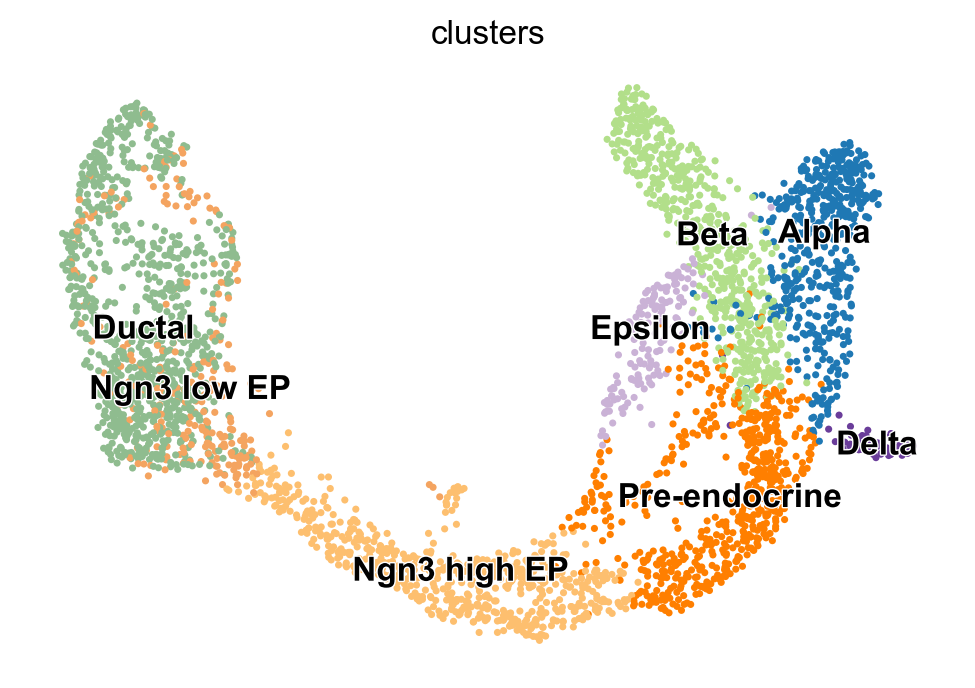

In [9]:
scv.pl.scatter(adata, basis='umap', frameon=False)


In [10]:
adata

AnnData object with n_obs × n_vars = 3696 × 2000
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'highly_variable_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu', 'velocity', 'variance_velocity'
    obsp: 'distances', 'connectivities'

In [11]:
target=list(adata.var_names)+['clusters']
target_dict={i:target[i] for i in range(2001)}

In [12]:
index=np.asarray(adata.obs['velocity_pseudotime'].argsort())

In [13]:
print("Distribution of cell types")
adata.obs.iloc[index,1].value_counts() #clusters

Distribution of cell types


Ductal           916
Ngn3 high EP     642
Pre-endocrine    592
Beta             591
Alpha            481
Ngn3 low EP      262
Epsilon          142
Delta             70
Name: clusters, dtype: int64

In [14]:
count_matrix=adata.X.toarray()[index,:]
clusters = np.expand_dims(np.asarray(adata.obs.iloc[index, 1]), axis=-1)
res=np.concatenate([count_matrix,clusters],axis=1)
df_pancreas=pd.DataFrame.from_records(res)
df_pancreas=df_pancreas.rename(columns=target_dict)

In [15]:
df_pancreas['clusters'].value_counts()

Ductal           916
Ngn3 high EP     642
Pre-endocrine    592
Beta             591
Alpha            481
Ngn3 low EP      262
Epsilon          142
Delta             70
Name: clusters, dtype: int64

In [16]:
preprocess_params={}
preprocess_params['window_size']=4
preprocess_params['stride']=2

In [18]:
cluster_names=[]
for x in clusters:
    if x not in cluster_names:
        cluster_names.append(x)
allowed_neighbours=[['Ductal','Ngn3 low EP'],['Ngn3 low EP','Ngn3 high EP'],['Ngn3 high EP','Pre-endocrine'],['Pre-endocrine','Alpha'],['Beta','Pre-endocrine'],['Pre-endocrine','Delta'],['Pre-endocrine','Epsilon']]
close_pairs=cluster_names+[set(x) for x in allowed_neighbours]

In [19]:
allowed_clusters=[set(pairs) for pairs in close_pairs]
rolling_avg = window_average_with_stride(df_pancreas, preprocess_params['window_size'], preprocess_params['stride'],allowed_clusters) # Rolling average
rolling_avg = rolling_avg[rolling_avg['clusters'] != 'Delta'] #Remove the cell type with less instances
cleaned_df=rolling_avg.dropna().reset_index(drop=True)

In [21]:
normalized=cleaned_df
col_names=normalized.columns.tolist()

normalized['Time']= range(1, (len(normalized))*preprocess_params['window_size'],preprocess_params['window_size']) #For calculating the time derivatives, each time step has been considered as one 
# elif params['time_step']=='dpt':
#     normalized=normalized.join(dpt_time_df['dpt_pseudotime'], how='inner') #previously stored dpt time is joined to the dpt_pseudotime column
#     normalized.rename(columns={'dpt_pseudotime': 'Time'}, inplace=True) #dpt_pseudotime is renamed to Time

dx=pd.DataFrame()
for names in col_names:
    if names!='clusters' and names not in 'Time': #More advanced derviatives can be considered
        dx[names]=(np.gradient(normalized[names],normalized['Time'])) #Finite difference method using np.gradient


In [22]:
# Example DataFrame setup
data = normalized['clusters']
temp = pd.DataFrame(data)

# Create dummies
dummy_df = pd.get_dummies(temp['clusters'])
# Convert to numpy array
class_ = dummy_df.values

# Get column names from dummy DataFrame, which are the cluster names
columns = dummy_df.columns.tolist()

# Create a mapping from array index to cluster name
class_idx_to_cell_type_dict = {i: name for i, name in enumerate(columns)}
# Display the mapping
pickle.dump(class_idx_to_cell_type_dict,open('class_idx_to_cell_type_dict.pkl','wb'))
class_idx_to_cell_type_dict


{0: 'Alpha',
 1: 'Beta',
 2: 'Ductal',
 3: 'Epsilon',
 4: 'Ngn3 high EP',
 5: 'Ngn3 low EP',
 6: 'Pre-endocrine'}

In [23]:
class_idx_to_cell_type_dict


{0: 'Alpha',
 1: 'Beta',
 2: 'Ductal',
 3: 'Epsilon',
 4: 'Ngn3 high EP',
 5: 'Ngn3 low EP',
 6: 'Pre-endocrine'}

In [24]:
class_=pd.get_dummies(normalized['clusters']).values
normalized.drop(columns=['clusters'], inplace=True) #dropping Time column as it is not needed in the training part
x=normalized.values #getting the values from the normalized dataframe so that it can be used for training
dx=dx.values #getting the values from the dx dataframe so that it can be used for training

In [25]:
training_dict={'x':x, 'dx':dx, 'classes':class_} #also add one hot encoding as 'class

In [26]:
with open('time_series.pkl', 'wb') as pkl_file:
    pickle.dump(training_dict, pkl_file)
with open('gene_names.pkl','wb') as pkl_file:
    pickle.dump(target_dict, pkl_file)
with open('preprocess_params.pkl','wb') as pkl_file:
    pickle.dump(preprocess_params,pkl_file)